Alankrita Pathak

**Goal**: Build out a data product and provide conclusions to help understand which ZIP Codes would generate the most profit on short term rentals within New York City. The real estate company has already concluded that two bedroom properties are the most profitable; however, they do not know which zip codes are the best to invest in.

### Assumptions:

#### General assumptions

1. Occupancy rate is 75%
2. The investor will pay for the property in cash
3. The time value of money discount rate is 0%
4. All properties and all square feet within each locale can be assumed to be homogeneous

#### Appreciation assumptions

1. **Home value appreciation**: Within a ZIP Code, the percentage increase in value of a property over a long period of time can be assumed to be a constant. In our case, we assume that the percent increase in home value from 2007-06 to 2017-06 will be the same as percent increase in the property from 2017-06 to 2027-06.
2. **Rental appreciation**: Within a ZIP Code, the percentage increase in rent is same as percentage increase in home value for the same time duration. (ie. from 2017 to 2027, if the value of a property increases by 10%, the rent on AirBnb for that property will also increase by 10%). This increase is assumed to be linear over 10 years to simplify calculations.


#### Other assumptions

1. **Return period**: The client aims to maximise returns over a 10 year period. We calculate profits assuming the property is purchased in 2017 June and the returns are calculated in 2027 June.
2. **Rental duration**: Since the real estate company is interested in short-term rentals, we ignore monthly/weekly discounted rates and assume all rentals happen on daily rates.
2. **Distribution of rental prices and home values**: Within a ZIP Code, we assume the rental rates and property prices follow a similar distibution.
3. **Ignoring maintenance, remodelling, renovation costs**: Since the rental prices are heavily dependent on how well a property is maintained and what ammenities are added, rating, reviews, condition of the property etc., this may or may not add a significant running cost. Since we are assuming properties to be homeogenous, we ignore such costs.

### Input:

1. Zillow provides us an estimate of value for two-bedroom properties
2. AirBnB is the medium through which the investor plans to lease out their investment property.

## Setup

In [1]:
# Load the required libraries and specify configuration options

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
from pylab import rcParams

# Constants
ZILLOW_INPUT = "Zip_Zhvi_2bedroom.csv"
AIRBNB_INPUT = "listings.csv"
OCCUPANCY_RATE = 0.75
DAYS_PER_YEAR = 365 # Ignoring leap years
RANDOM_SEED = 1234567 # To reproduce results

# Plotting options
%matplotlib inline
rcParams['figure.figsize'] = 10, 8

## Part 1) Loading AirBnb Data

### Filtering

According to the problem statement, the real estate company

> "has a niche in purchasing properties to rent out short-term as part of their business model specifically within New York City."

> "has already concluded that two bedroom properties are the most profitable"

- The AirBnb dataset is only for New York, we do not have to filter for city.
- Since the company purchases and rents out property, we keep only "Entire home/apt" as room type, as price model for private/shared rooms in AirBnb involve involves other factors like host rating etc. as those have hosts staying with guests and is a part of the experience.
- We will remove all listings from our dataset that are not 2 bed rooms.

In [2]:
# Loading AirBnb data

relevant_columns = ['price', 'last_scraped', 'bedrooms','room_type','zipcode', 'square_feet']

airbnb_df = pd.read_csv(AIRBNB_INPUT, usecols=relevant_columns, low_memory=False)

# formating the price to remove $ sign and comma.
airbnb_df['price'] = airbnb_df['price'].astype(str).str.replace('$','').str.replace(',','')
airbnb_df['price'] = pd.to_numeric(airbnb_df['price'])
airbnb_df.rename(columns={'price': 'rent_2017'}, inplace=True)

# formating the zip code to remove 4 digit route numbers.
airbnb_df['zipcode'] = airbnb_df['zipcode'].str.split('-').str[0]
airbnb_df['zipcode'] = pd.to_numeric(airbnb_df['zipcode'], errors='coerce', downcast='integer').fillna(0).astype('int')
airbnb_df = airbnb_df.loc[airbnb_df['zipcode'] > 0]

# Filtering data to keep entire homes/apt with 2 bedrooms
airbnb_df = airbnb_df.loc[airbnb_df['bedrooms'] == 2.0]
airbnb_df = airbnb_df.loc[airbnb_df['room_type'] == 'Entire home/apt']

### Validating time frame of data

To validate whether all data is within a certain time frame, we take the min and max of last scraped time

In [3]:
print(airbnb_df.last_scraped.min())
print(airbnb_df.last_scraped.max())

2017-05-02
2017-05-05


Since, the date range is "2017-05-02" to "2017-05-05", we can treat this as price for 2017-05. Also, we use month level granuality for rent, as we only have month level granuality for the house value data.

### Aggregation

Grouping data for all AirBnb lease/rentals by ZIP Code to find aggregate price.

We start by looking at what fraction of the listings we are using have square foot data.

In [4]:
# Percentage of listings with missing square feet data
len(airbnb_df.loc[airbnb_df['square_feet'].isnull()])/len(airbnb_df)*100

97.61852260198457

Since 97.6% of our AirBnb data for New York 2 bedroom apartment listing doesn't have square feet information, this data is too sparse to include in our analysis.

We use **median** similar to the home value data from Zillow. We are not using weighted average or any other measure to include the effect of square feet as the square feet data is very sparse.

In [5]:
# Finding median prices grouped by ZIP Code.
airbnb_df=airbnb_df.groupby(['zipcode'])[['rent_2017']].median().reset_index()

airbnb_df

,zipcode,rent_2017
0,10001,362.5
1,10002,240.0
2,10003,250.0
3,10004,333.0
4,10005,200.0
5,10006,250.0
6,10007,472.5
7,10009,249.0
8,10010,300.0
9,10011,316.5


## Part 2) Loading Home Value data (Zillow)

### Filtering

Since the real estate agency is interested only in New York, we filter the data to keep only the data for New York. In this data, New York includes all 5 boroughs.

In [6]:
# Loading Zillow Data

zillow_df = pd.read_csv(ZILLOW_INPUT)

# Filter to keep only New York City data.
zillow_df = zillow_df.loc[zillow_df['City'] == 'New York']

# Drop columns we don't need
zillow_df = zillow_df.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

zillow_df.rename(columns={'RegionName': 'zipcode', '2007-06': 'price_2007', '2017-06': 'price_2017'}, inplace=True)

### Exploratory Data Analysis

#### Price trend over time

First, we start looking at price trend over time for 10 randomly sampled ZIP Codes.

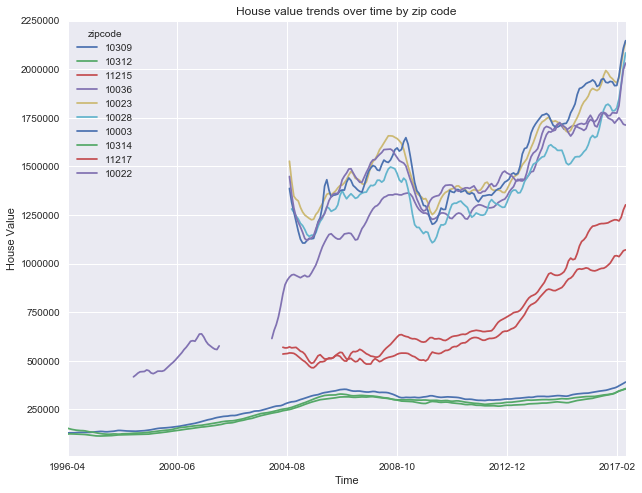

In [7]:
# Plot price trend over time

graph = zillow_df.sample(n=10, random_state=RANDOM_SEED).set_index('zipcode').transpose().plot(title='House value trends over time by zip code')

graph.set_xlabel('Time')
graph.set_ylabel('House Value')

zillow_df = zillow_df.reset_index()

The graph shows the fluctuations due to [US housing bubble](https://en.wikipedia.org/wiki/Timeline_of_the_United_States_housing_bubble), however we are doing a long-term analysis (~10 years) so we ignore the effects of housing bubble and also ignore the possibility of any similar events occuring in the next 10 years.

## Part 3) Combined Analysis

### Merging the data

Joining the data from AirBnb and Zillow based on ZIP Code.

In [8]:
# Keep only columns we need in Zillow
zillow_df = zillow_df[['zipcode', 'price_2007', 'price_2017']]

merged = pd.merge(airbnb_df,zillow_df, on='zipcode', how='inner')
merged.head()

,zipcode,rent_2017,price_2007,price_2017
0,10003,250.0,1367700.0,2147000
1,10011,316.5,1514600.0,2480400
2,10013,300.0,2090200.0,3316500
3,10014,299.0,1505800.0,2491600
4,10021,225.0,1223900.0,1815600


### Predicting profit over 10 years

We use the [appreciation assumptions](#Appreciation-assumptions) above for predicting the rental rates and home value over the period of time from 2017 to 2027.

Mathematically,

For Home Value

```
Percent Increase in Home Value from 2017 to 2027 = Percent Increase in Home Value from 2007 to 2017
```

For rental rates

```
Percent Increase in Rent from 2017 to 2027 = Percent Increase in Home Value from 2017 to 2027
```

Calculating total profit

```
Predicted ROI % = (Profit from rentals + Home value appreciation) / (Median house value in 2017) * 100

```
where,

- Income from AirBnb rentals = (Daily rent in 2017 + Predicted daily rent in 2027) / 2 \* (Occupancy rate) \* (365 * 10)
- Income from House Value appreciation = Predicted house value for 2027 - House value in 2017.




In [9]:
# Calculate appreciation rate over 10 year period
merged['appreciation_rate'] = (merged.price_2017 - merged.price_2007)/(merged.price_2007)

# Income from Home Value appreciation
merged['price_2027'] = merged.price_2017 * (1 + merged.appreciation_rate)
merged['house_value_appreciation'] = merged.price_2027 - merged.price_2017

# Income from Rent
merged['rent_2027'] = merged.rent_2017 * (1 + merged.appreciation_rate)
merged['profit_from_rent'] = merged[['rent_2017', 'rent_2027']].mean(axis=1) * OCCUPANCY_RATE * DAYS_PER_YEAR * 10

# Total profit and ROI percent
merged['total_profit'] = merged.profit_from_rent + merged.house_value_appreciation
merged['roi_percent'] = (merged.total_profit / merged.price_2017) * 100;

# Sort the data by RPO
merged = merged.sort_values(by=['roi_percent'], ascending=[False])
merged.head()

,zipcode,rent_2017,price_2007,price_2017,appreciation_rate,price_2027,house_value_appreciation,rent_2027,profit_from_rent,total_profit,roi_percent
18,11217,195.0,553600.0,1302300,1.352421,3.063557e+06,1.761257e+06,458.722001,894781.989478,2.656039e+06,203.949876
16,11201,189.0,600400.0,1420700,1.366256,3.361740e+06,1.941040e+06,447.222352,870829.343979,2.811869e+06,197.921377
15,10312,215.0,321900.0,355000,0.102827,3.915036e+05,3.650357e+04,237.107797,618822.547763,6.553261e+05,184.598907
19,11231,192.5,560500.0,1202900,1.146120,2.581567e+06,1.378667e+06,413.128011,828953.339652,2.207621e+06,183.524859
17,11215,165.0,503100.0,1070800,1.128404,2.279095e+06,1.208295e+06,351.186643,706530.467352,1.914825e+06,178.821942


### Metadata for derived fields

- *appreciation_rate*: Rate at which the price for home value has increased from 2007 to 2017
- *price_2027*: Predicted Price based on the appreciation rate
- *house_value_appreciation*: Difference in home value price between 2027 and 2017
- *rent_2027*: Predicted Airbnb rate based on the appreciation rate
- *profit_from_rent*: Predicted profit earned over 10 years from the predicted rental prices 
- *total_profit*: Total predicted profit from Rent and Home Value appreciation
- *roi_percent*: Percent predicted return on investment



## Part 4) Visualizing the data

### Change in house value over time

The following graphs show the change in house value between 2017 and 2027 for different zip codes. This helps us determine which zip codes will give the real estate company better returns in terms of appreciation of the property itself.

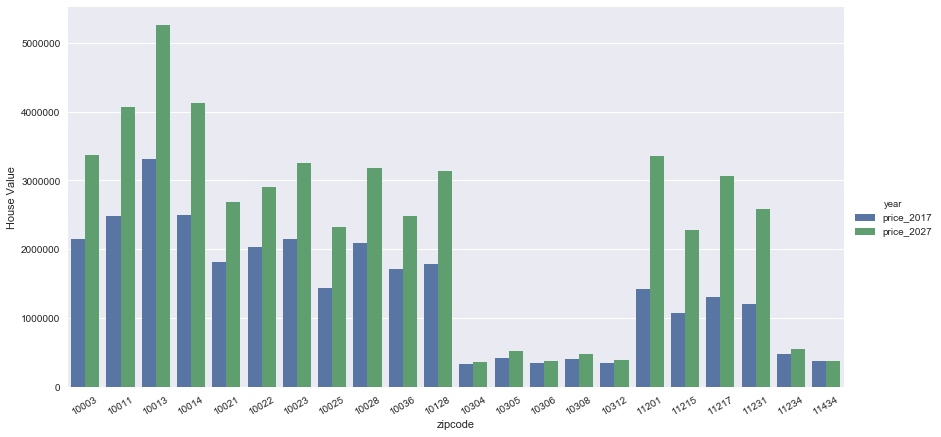

In [10]:
df = pd.melt(merged[['zipcode', 'price_2017', 'price_2027']], id_vars="zipcode", var_name="year", value_name="House Value")

graph = sns.factorplot(x='zipcode', y='House Value', hue='year', data=df, kind='bar', size=6, aspect=2)
graph.set_xticklabels(rotation=30)

### Overall return on investment percentage over time

Apart from the increase in value of the property itself, another component of the income is the money earnt from short-term lease via AirBnb.

The following graphs, shows the predicted ROI (Return on investment) percentage over the period of 10 years (2017 to 2027) combining income from the above two sources.

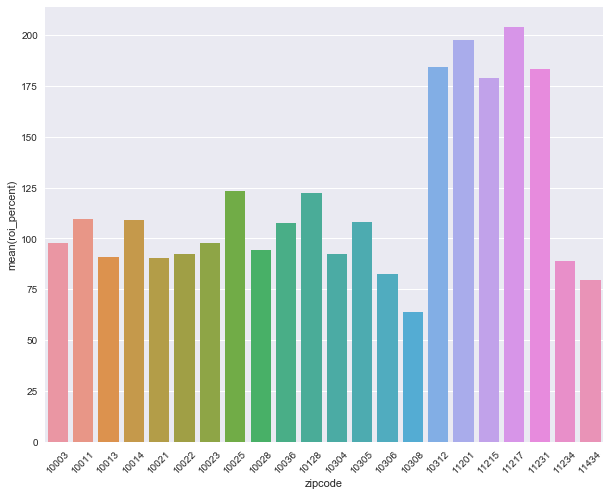

In [11]:
plt.xticks(rotation=45)

sns.set(rc={'figure.figsize':(16,8)})

sns.barplot(x='zipcode', y='roi_percent', data=merged)

In [12]:
# List the top 5 zip codes to invest based on Predicted ROI Percentage.
merged.head(n=5)[['zipcode', 'price_2017', 'profit_from_rent', 'house_value_appreciation', 'total_profit', 'roi_percent']]

,zipcode,price_2017,profit_from_rent,house_value_appreciation,total_profit,roi_percent
18,11217,1302300,894781.989478,1.761257e+06,2.656039e+06,203.949876
16,11201,1420700,870829.343979,1.941040e+06,2.811869e+06,197.921377
15,10312,355000,618822.547763,3.650357e+04,6.553261e+05,184.598907
19,11231,1202900,828953.339652,1.378667e+06,2.207621e+06,183.524859
17,11215,1070800,706530.467352,1.208295e+06,1.914825e+06,178.821942


## Part 6) Conclusion

Based on the roi percentage , top five zipcodes that would provide most profilt in New York City would be '11217', '11217', '11231', '11215', '10128'. These ZIP codes will provide higher return on investement on short term rentals.

For the ZIP Code 11217, the real-estate agency should be able to triple their money every 10 years with ROI of 203.94% in 10 years. This is equivalent to earning with a compound annual interest of 11.75%. illustrated with the graph below.

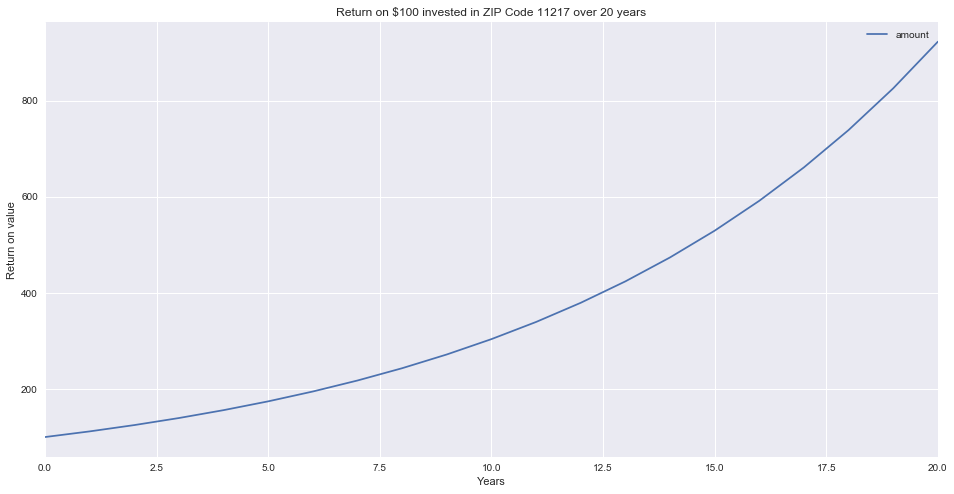

In [13]:
# Plot the growth of money over time for ZIP Code with highest ROI.

principle = 100
rate_of_interest = 11.75

def compound_interest(num_years):
    return principle * (((1 + (rate_of_interest/100.0)) ** (num_years)))

years=list(range(0,21))
years_df = pd.DataFrame({'year':years})
years_df['amount'] = years_df['year'].map(compound_interest)
graph = years_df.set_index('year').plot(title='Return on $100 invested in ZIP Code 11217 over 20 years')

graph.set_xlabel('Years')
graph.set_ylabel('Return on value')

## Part 7) Future work / Improvements

### Informing a better decision

- **Improving prediction for price appreciation**: Using regression with OLS or Random Forest would account for noise in the data and help us make a more accurate prediction for house values. With more time, we can use Ensemble methods that construct a set of classifiers and then classify new data points by taking a weighted vote of their predictions.
- **Modeling occupancy rates for ZIP codes**: Using availability data along with number of reviews to compute occupancy rate by ZIP Codes would give us a better picture of occupancy rates for different zip codes.

### Developing a better product

- **Plotting the analysis visually on a map**: ZIP Codes aren't very informative way to present results by itself. Presenting the ROI on a map would help the real estate company visually understand the results better.

